# Credit Card Approval Prediction

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import scipy.stats as stats
import joblib
import os
%matplotlib inline

## Load dataset

In [57]:
# Load datasets
application_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')

In [26]:
application_df.shape, credit_df.shape

((438557, 18), (1048575, 3))

In [27]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [28]:
credit_df['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

From the dataset info:

0: paid on time

1: 1 month delay

2-5: longer delays

C: closed

X: no loan

## Creating the target variable

In [58]:
begin_month = credit_df.groupby('ID', as_index=False)['MONTHS_BALANCE'].agg('min')
begin_month = begin_month.rename(columns={'MONTHS_BALANCE': 'Account age'})
application_df = pd.merge(application_df, begin_month, how='left', on='ID')
credit_df['dep_value'] = None
credit_df.loc[credit_df['STATUS'].isin(['2', '3', '4', '5']), 'dep_value'] = 'Yes'
cpunt = credit_df.groupby('ID')['dep_value'].count().reset_index()
cpunt['dep_value'] = cpunt['dep_value'].apply(lambda x: 'Yes' if x > 0 else 'No')
application_df = pd.merge(application_df, cpunt, how='inner', on='ID')
application_df['Is high risk'] = application_df['dep_value'].map({'Yes': 1, 'No': 0})

# Drop temporary column
application_df.drop('dep_value', axis=1, inplace=True)

In [30]:
application_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,0


In [31]:
application_df['Is high risk'].value_counts()

Is high risk
0    35841
1      616
Name: count, dtype: int64

## Rename features

In [59]:
full_data = application_df.copy()

In [60]:
# rename the features to a more readable feature names
full_data = full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

In [61]:
columns_to_rename = ["Gender", "Has a car", "Has a property", "Has a mobile phone" , "Has a work phone", "Has a phone", "Has an email"]
full_data[columns_to_rename] = full_data[columns_to_rename].replace({"M": "Male", "F": "Female", "Y": "Yes", "N": "No", 1: "Yes", 0: "No"})

In [35]:
full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,Male,Yes,Yes,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,Yes,Yes,No,No,NaN,2.0,-15.0,0
1,5008805,Male,Yes,Yes,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,Yes,Yes,No,No,NaN,2.0,-14.0,0
2,5008806,Male,Yes,Yes,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Yes,No,No,No,Security staff,2.0,-29.0,0
3,5008808,Female,No,Yes,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Yes,No,Yes,Yes,Sales staff,1.0,-4.0,0
4,5008809,Female,No,Yes,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Yes,No,Yes,Yes,Sales staff,1.0,-26.0,0


## Fix Age and Employment length

In [62]:
full_data['Age'] = (full_data['Age']*-1) // 365
full_data['Employment length'] = (full_data['Employment length']*-1) // 365
full_data['Account age'] = (full_data['Account age']*-1)

In [63]:
# full_data[full_data['Employment length'] < 0].head()

In [63]:
# Replace with -1001 with a 0
full_data['Employment length'] = full_data['Employment length'].replace(-1001, 0)

In [64]:
full_data['Job title'] = full_data['Job title'].fillna('Retired')

In [66]:
# full_data.to_csv("Cleaned_application_df.csv")

# Exploratory Data Analysis (EDA)

## Overview of the Dataset

In [39]:
# Check dataset shape
print(f"Dataset contains {full_data.shape[0]} rows and {full_data.shape[1]} columns.")

# Check column data types and missing values
print(full_data.info())

# Summary statistics
full_data.describe()

Dataset contains 36457 rows and 20 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  object 
 13  Has a work phone     36457 non-null  object 
 14  Has a phone          36457 non-null  objec

,ID,Children count,Income,Age,Employment length,Family member count,Account age,Is high risk
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,43.260334,5.614560,2.198453,26.164193,0.016897
std,4.187524e+04,0.742367,1.017892e+05,11.510414,6.417027,0.911686,16.501854,0.128886
min,5.008804e+06,0.000000,2.700000e+04,20.000000,0.000000,1.000000,-0.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,34.000000,1.000000,2.000000,12.000000,0.000000
50%,5.074614e+06,0.000000,1.575000e+05,42.000000,4.000000,2.000000,24.000000,0.000000
75%,5.115396e+06,1.000000,2.250000e+05,53.000000,8.000000,3.000000,39.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,68.000000,43.000000,20.000000,60.000000,1.000000


In [40]:
# Drop ID column
full_data.drop(columns=["ID"], inplace=True)

## Missing Values

In [41]:
# Check missing values
full_data.isnull().sum().sort_values(ascending=False)

Gender                 0
Employment length      0
Account age            0
Family member count    0
Job title              0
Has an email           0
Has a phone            0
Has a work phone       0
Has a mobile phone     0
Age                    0
Has a car              0
Dwelling               0
Marital status         0
Education level        0
Employment status      0
Income                 0
Children count         0
Has a property         0
Is high risk           0
dtype: int64

## Univariate Analysis

### Numerical Features

In [42]:
def univariate_analysis(data):
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop(['Is high risk'], errors='ignore')

    for column in numeric_columns:
        print(f'\nAnalysis for {column}:\n')
        print(data[column].describe())
        
        plt.figure(figsize=(12, 6))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(f'Histogram of {column}')
        
        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=data[column])
        plt.title(f'Box Plot of {column}')
        
        plt.tight_layout()
        plt.show()


Analysis for Children count:

count    36457.000000
mean         0.430315
std          0.742367
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64


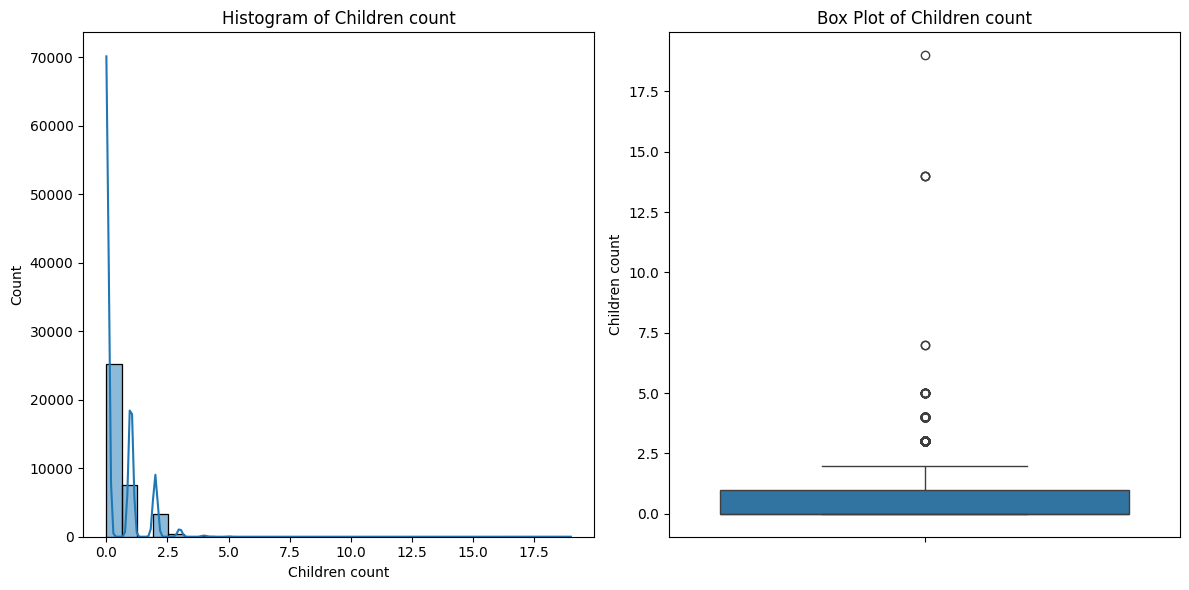


Analysis for Income:

count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: Income, dtype: float64


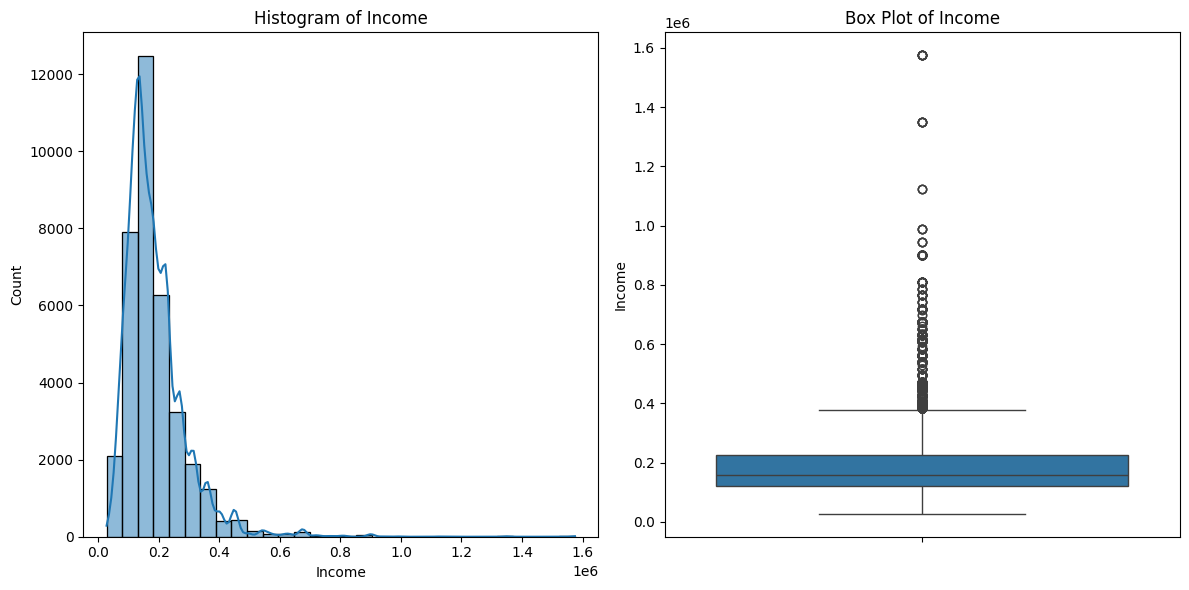


Analysis for Age:

count    36457.000000
mean        43.260334
std         11.510414
min         20.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         68.000000
Name: Age, dtype: float64


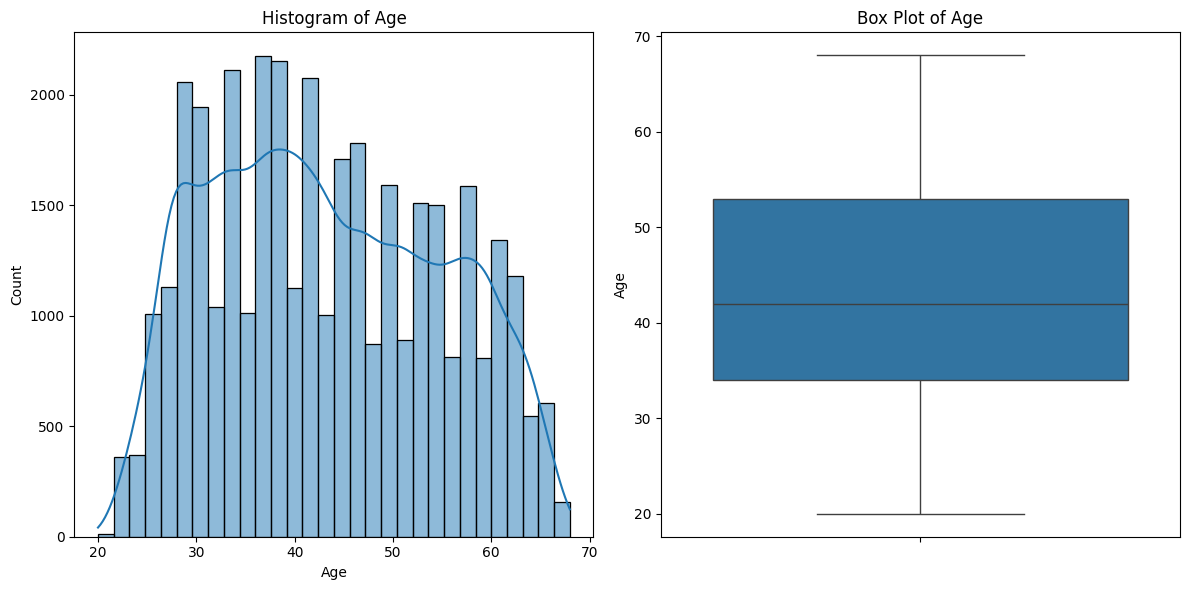


Analysis for Employment length:

count    36457.000000
mean         5.614560
std          6.417027
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max         43.000000
Name: Employment length, dtype: float64


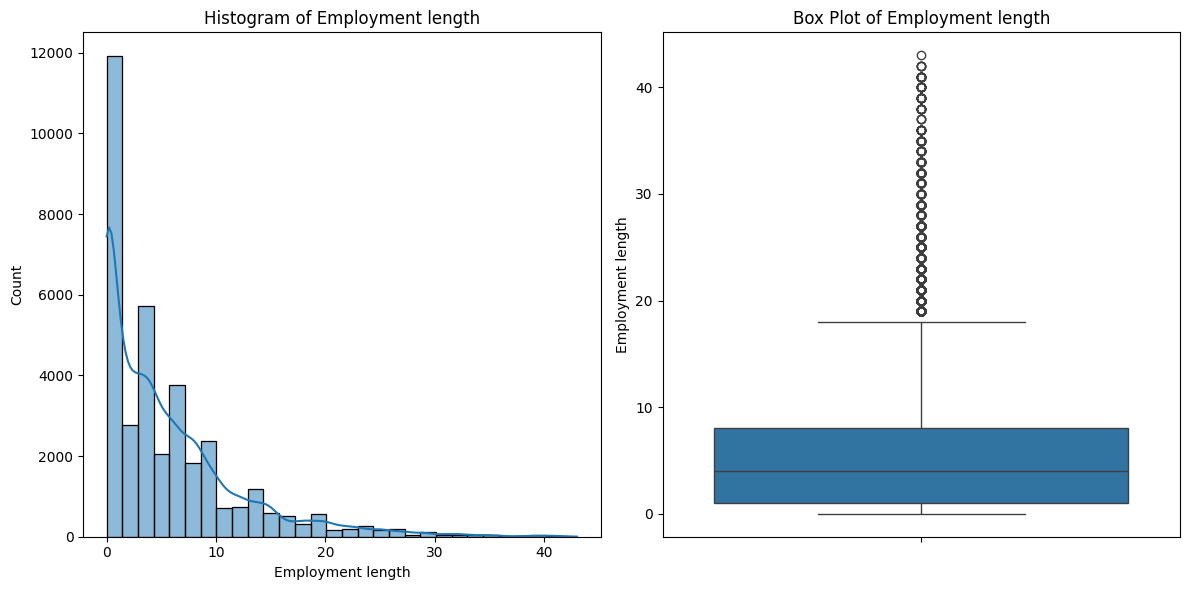


Analysis for Family member count:

count    36457.000000
mean         2.198453
std          0.911686
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64


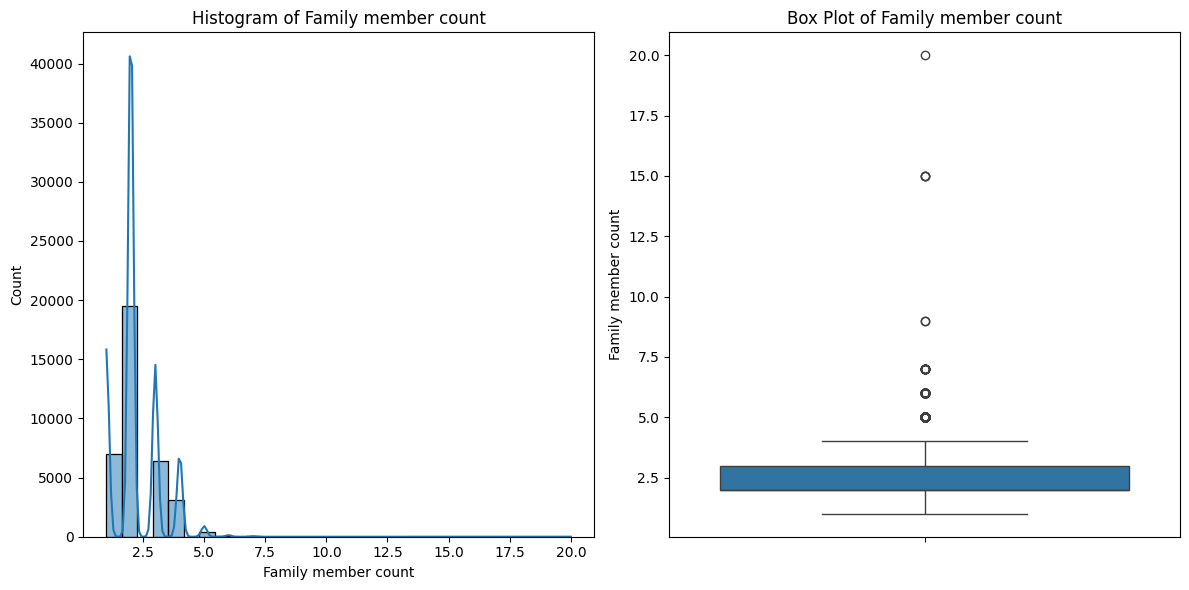


Analysis for Account age:

count    36457.000000
mean        26.164193
std         16.501854
min         -0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account age, dtype: float64


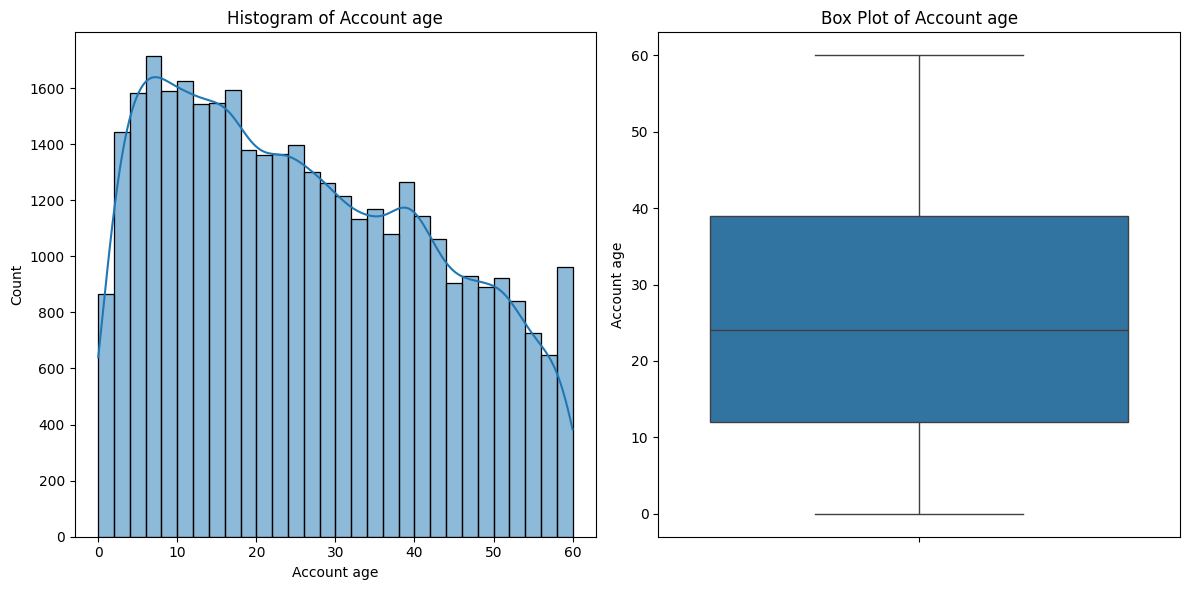

In [43]:
univariate_analysis(full_data)

- A few individuals report extremely high income, likely business owners or anomalies, which could mislead models into overweighting income unless handled properly.
- The age distribution is fairly symmetric
- The skew suggests a concentration of applicants with low job tenure, while a few may have long careers or are retired

### Categorical Features

In [44]:
def categorical_univariate_analysis(data):
    # Select categorical columns
    categorical_columns = data.select_dtypes(include=['object'])

    for column in categorical_columns:
        print(f'\n Analysis for categorical feature: {column}')
        
        # Basic description
        print("Description:")
        print(data[column].describe())

        print("**************************************************")
        print("Object type:")
        print(data[column].dtype)
        print("**************************************************")

        # Value counts with percentage
        value_counts = data[column].value_counts(dropna=False)
        value_percent = round((value_counts / len(data)) * 100, 2)
        value_df = pd.DataFrame({'Count': value_counts, 'Frequency (%)': value_percent})
        print("Value count:\n", value_df)

        # Bar chart
        plt.figure(figsize=(6,10))
        sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)
        plt.title(f'Bar Chart of {column}')
        plt.xlabel(column)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


 Analysis for categorical feature: Gender
Description:
count      36457
unique         2
top       Female
freq       24430
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
         Count  Frequency (%)
Gender                      
Female  24430          67.01
Male    12027          32.99


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


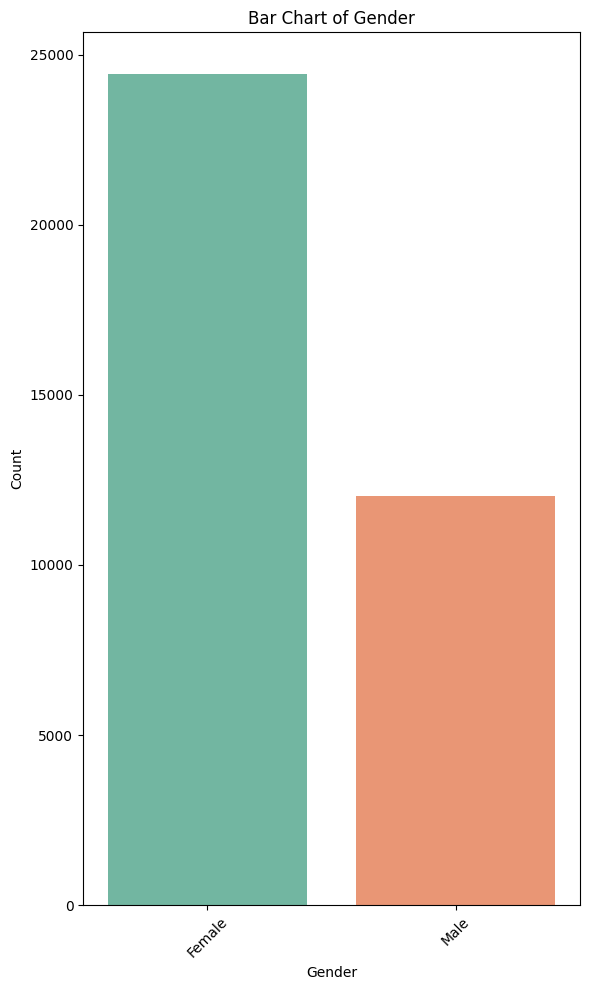


 Analysis for categorical feature: Has a car
Description:
count     36457
unique        2
top          No
freq      22614
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
            Count  Frequency (%)
Has a car                      
No         22614          62.03
Yes        13843          37.97


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


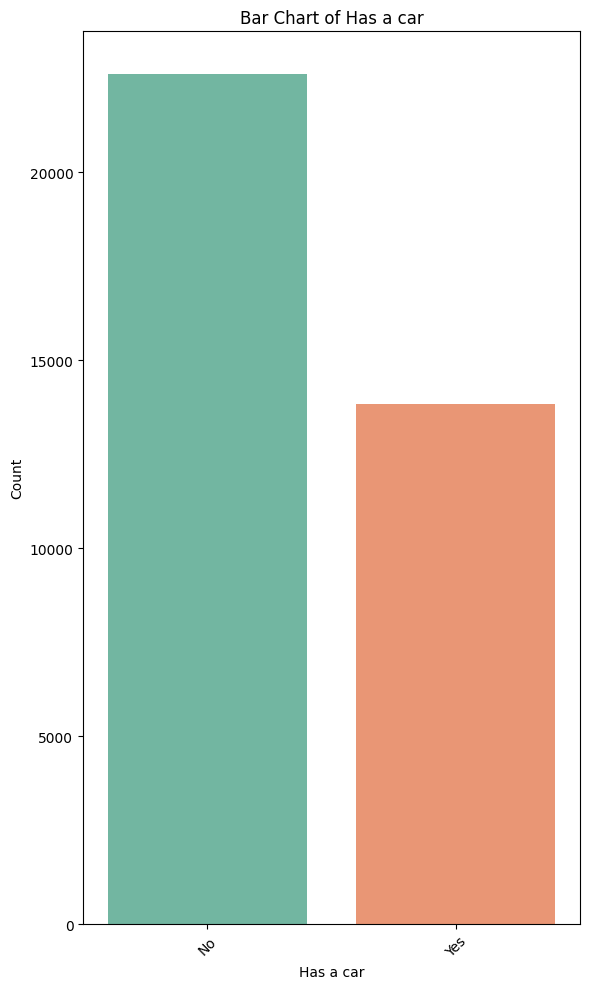


 Analysis for categorical feature: Has a property
Description:
count     36457
unique        2
top         Yes
freq      24506
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                 Count  Frequency (%)
Has a property                      
Yes             24506          67.22
No              11951          32.78


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


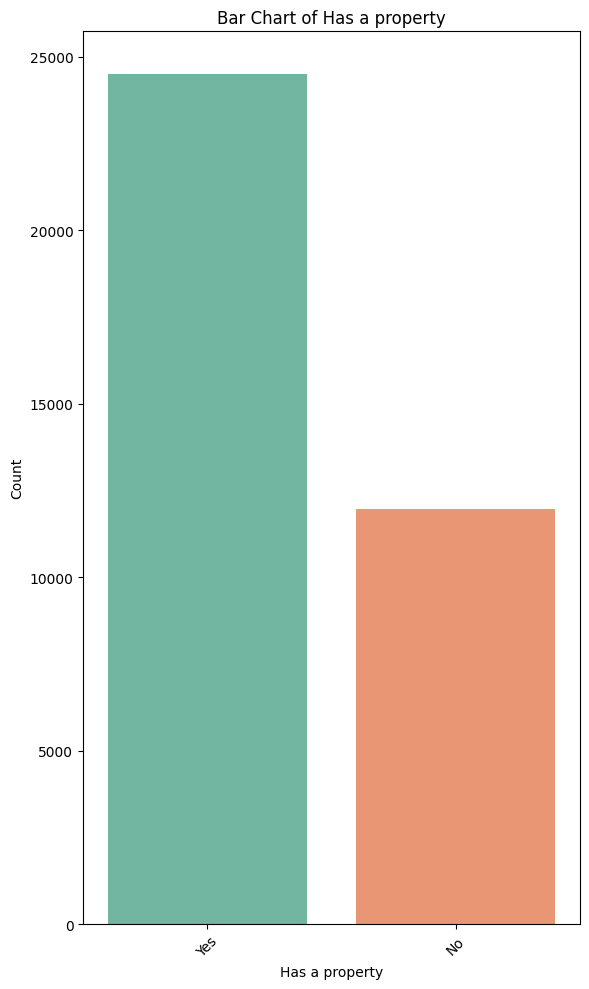


 Analysis for categorical feature: Employment status
Description:
count       36457
unique          5
top       Working
freq        18819
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Employment status                         
Working               18819          51.62
Commercial associate   8490          23.29
Pensioner              6152          16.87
State servant          2985           8.19
Student                  11           0.03


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


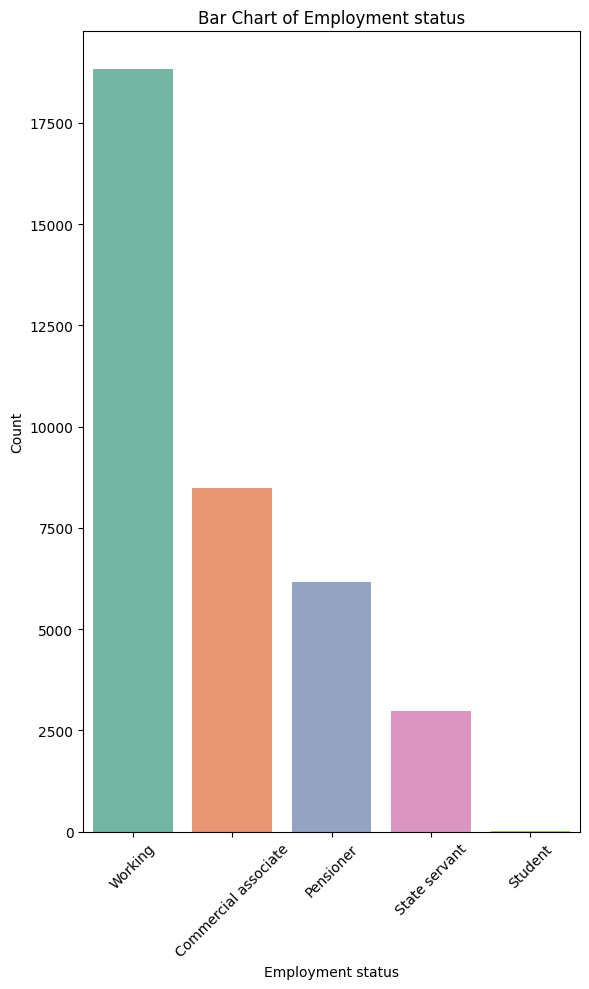


 Analysis for categorical feature: Education level
Description:
count                             36457
unique                                5
top       Secondary / secondary special
freq                              24777
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                                Count  Frequency (%)
Education level                                    
Secondary / secondary special  24777          67.96
Higher education                9864          27.06
Incomplete higher               1410           3.87
Lower secondary                  374           1.03
Academic degree                   32           0.09


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


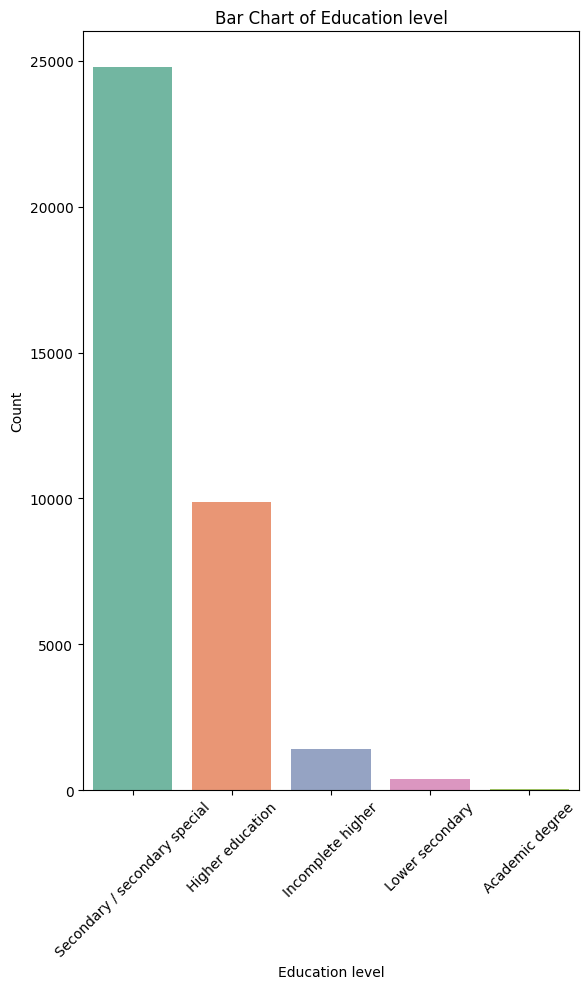


 Analysis for categorical feature: Marital status
Description:
count       36457
unique          5
top       Married
freq        25048
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Marital status                            
Married               25048          68.71
Single / not married   4829          13.25
Civil marriage         2945           8.08
Separated              2103           5.77
Widow                  1532           4.20


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


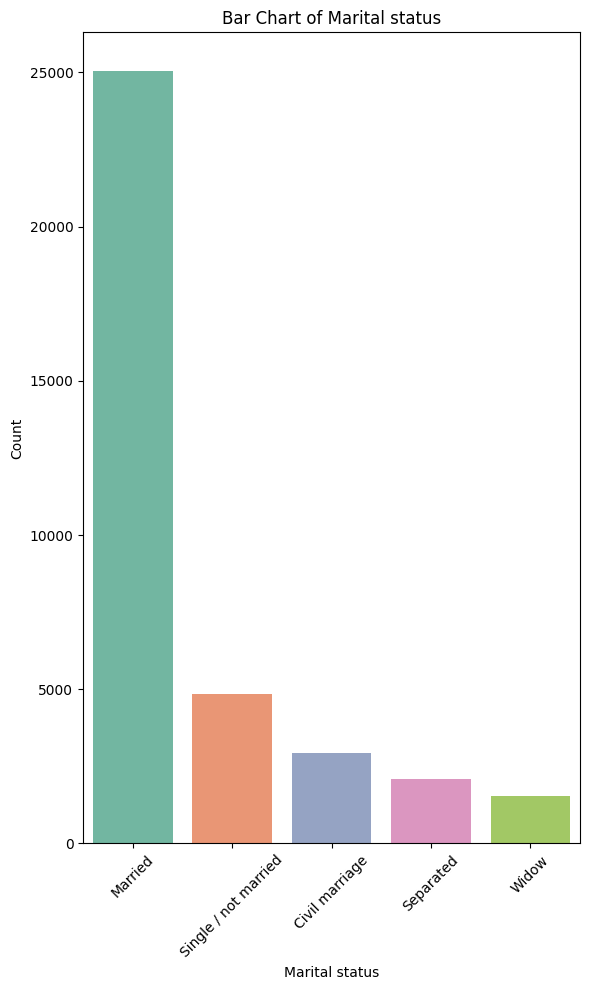


 Analysis for categorical feature: Dwelling
Description:
count                 36457
unique                    6
top       House / apartment
freq                  32548
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Dwelling                                 
House / apartment    32548          89.28
With parents          1776           4.87
Municipal apartment   1128           3.09
Rented apartment       575           1.58
Office apartment       262           0.72
Co-op apartment        168           0.46


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


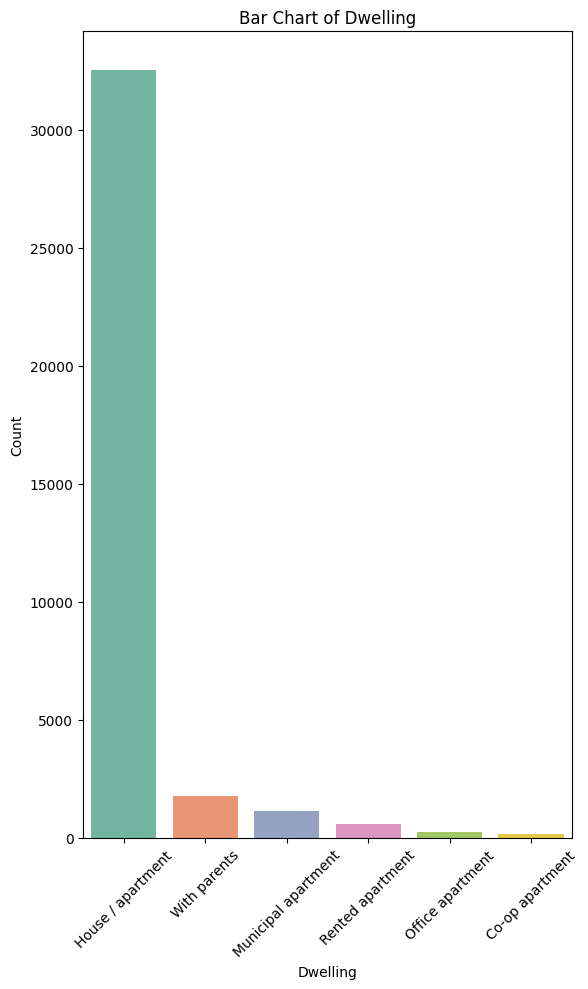


 Analysis for categorical feature: Has a mobile phone
Description:
count     36457
unique        1
top         Yes
freq      36457
Name: Has a mobile phone, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
Has a mobile phone                      
Yes                 36457          100.0


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


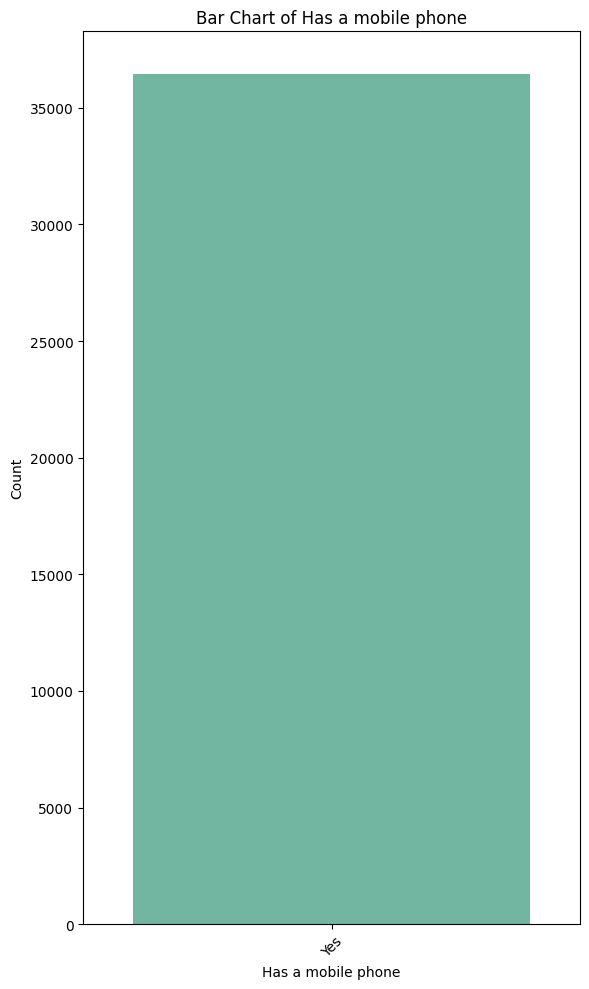


 Analysis for categorical feature: Has a work phone
Description:
count     36457
unique        2
top          No
freq      28235
Name: Has a work phone, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                   Count  Frequency (%)
Has a work phone                      
No                28235          77.45
Yes                8222          22.55


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


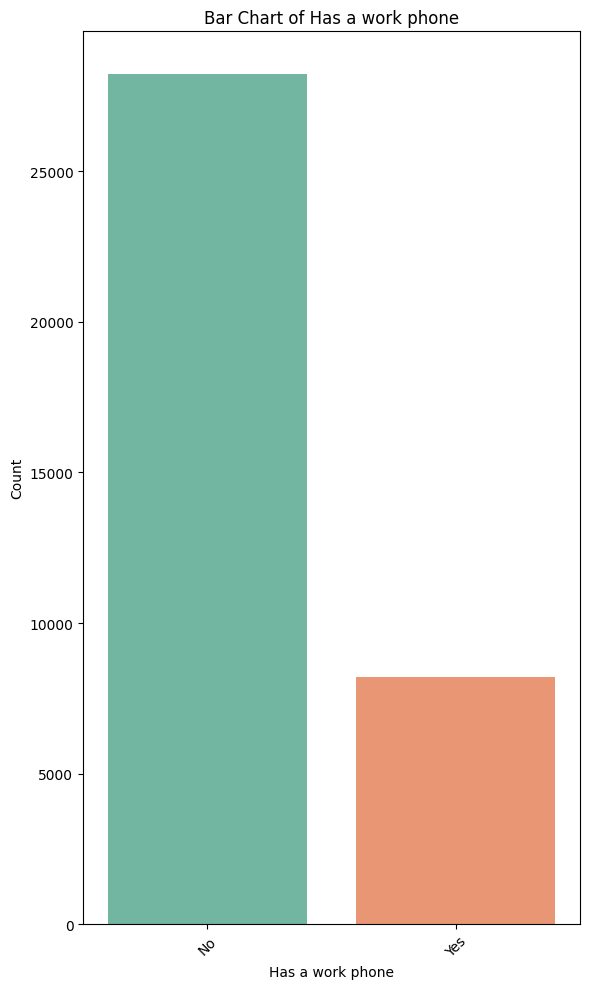


 Analysis for categorical feature: Has a phone
Description:
count     36457
unique        2
top          No
freq      25709
Name: Has a phone, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
              Count  Frequency (%)
Has a phone                      
No           25709          70.52
Yes          10748          29.48


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


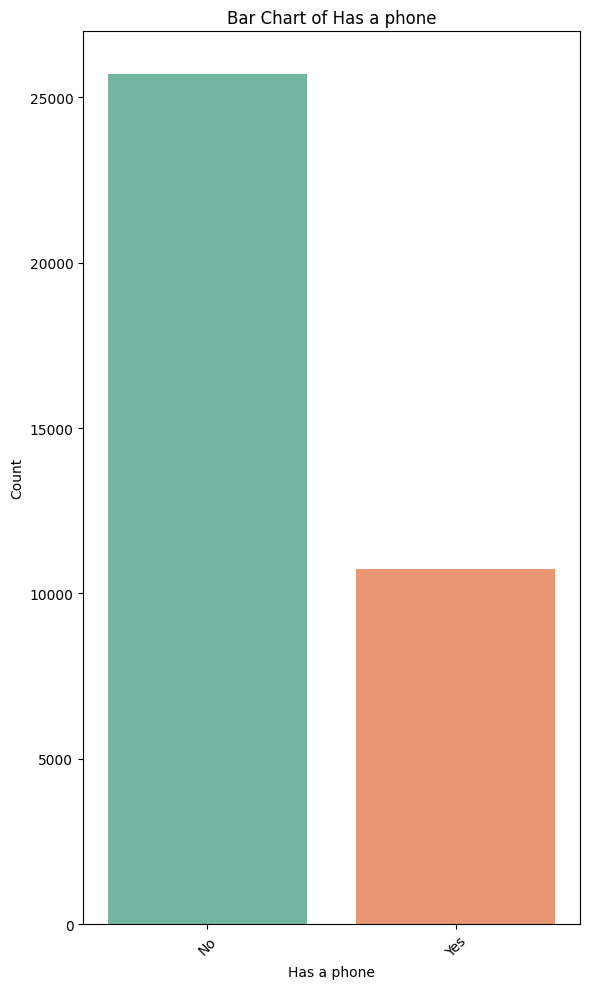


 Analysis for categorical feature: Has an email
Description:
count     36457
unique        2
top          No
freq      33186
Name: Has an email, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
               Count  Frequency (%)
Has an email                      
No            33186          91.03
Yes            3271           8.97


C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


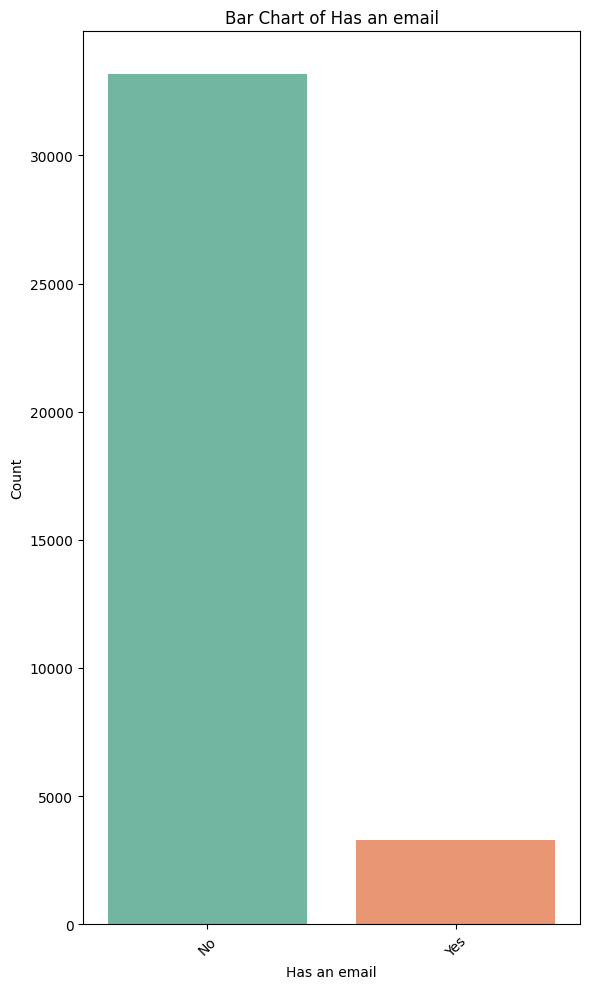


 Analysis for categorical feature: Job title
Description:
count       36457
unique         19
top       Retired
freq        11323
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                        Count  Frequency (%)
Job title                                  
Retired                11323          31.06
Laborers                6211          17.04
Core staff              3591           9.85
Sales staff             3485           9.56
Managers                3012           8.26
Drivers                 2138           5.86
High skill tech staff   1383           3.79
Accountants             1241           3.40
Medicine staff          1207           3.31
Cooking staff            655           1.80
Security staff           592           1.62
Cleaning staff           551           1.51
Private service staff    344           0.94
Low-skill Laborers       175           0.4

C:\Users\User\AppData\Local\Temp\ipykernel_6044\44614084.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='Set2', order=value_counts.index)


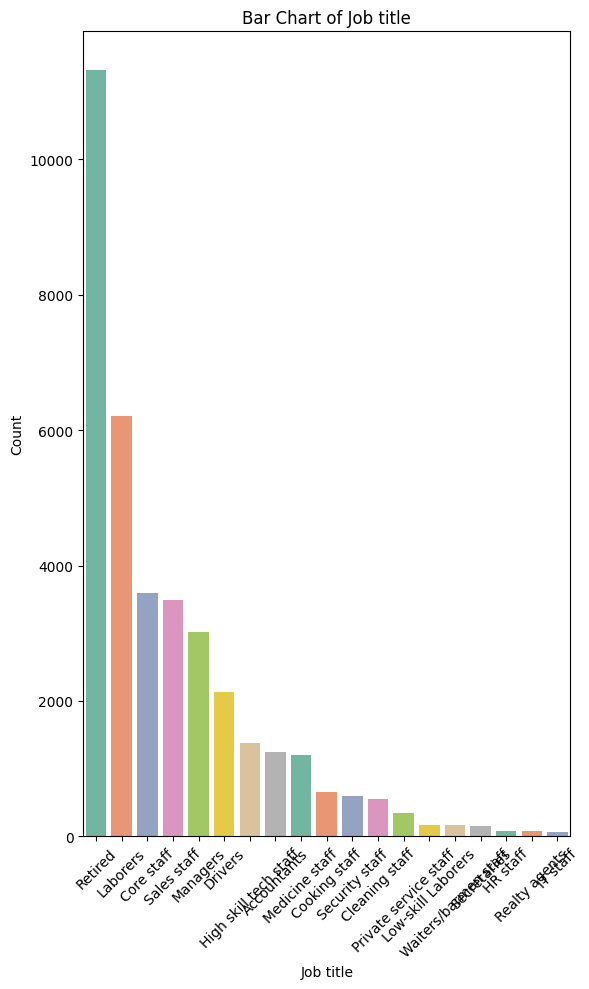

In [45]:
categorical_univariate_analysis(full_data)

## Bivariate Analysis

### Scatter Plots

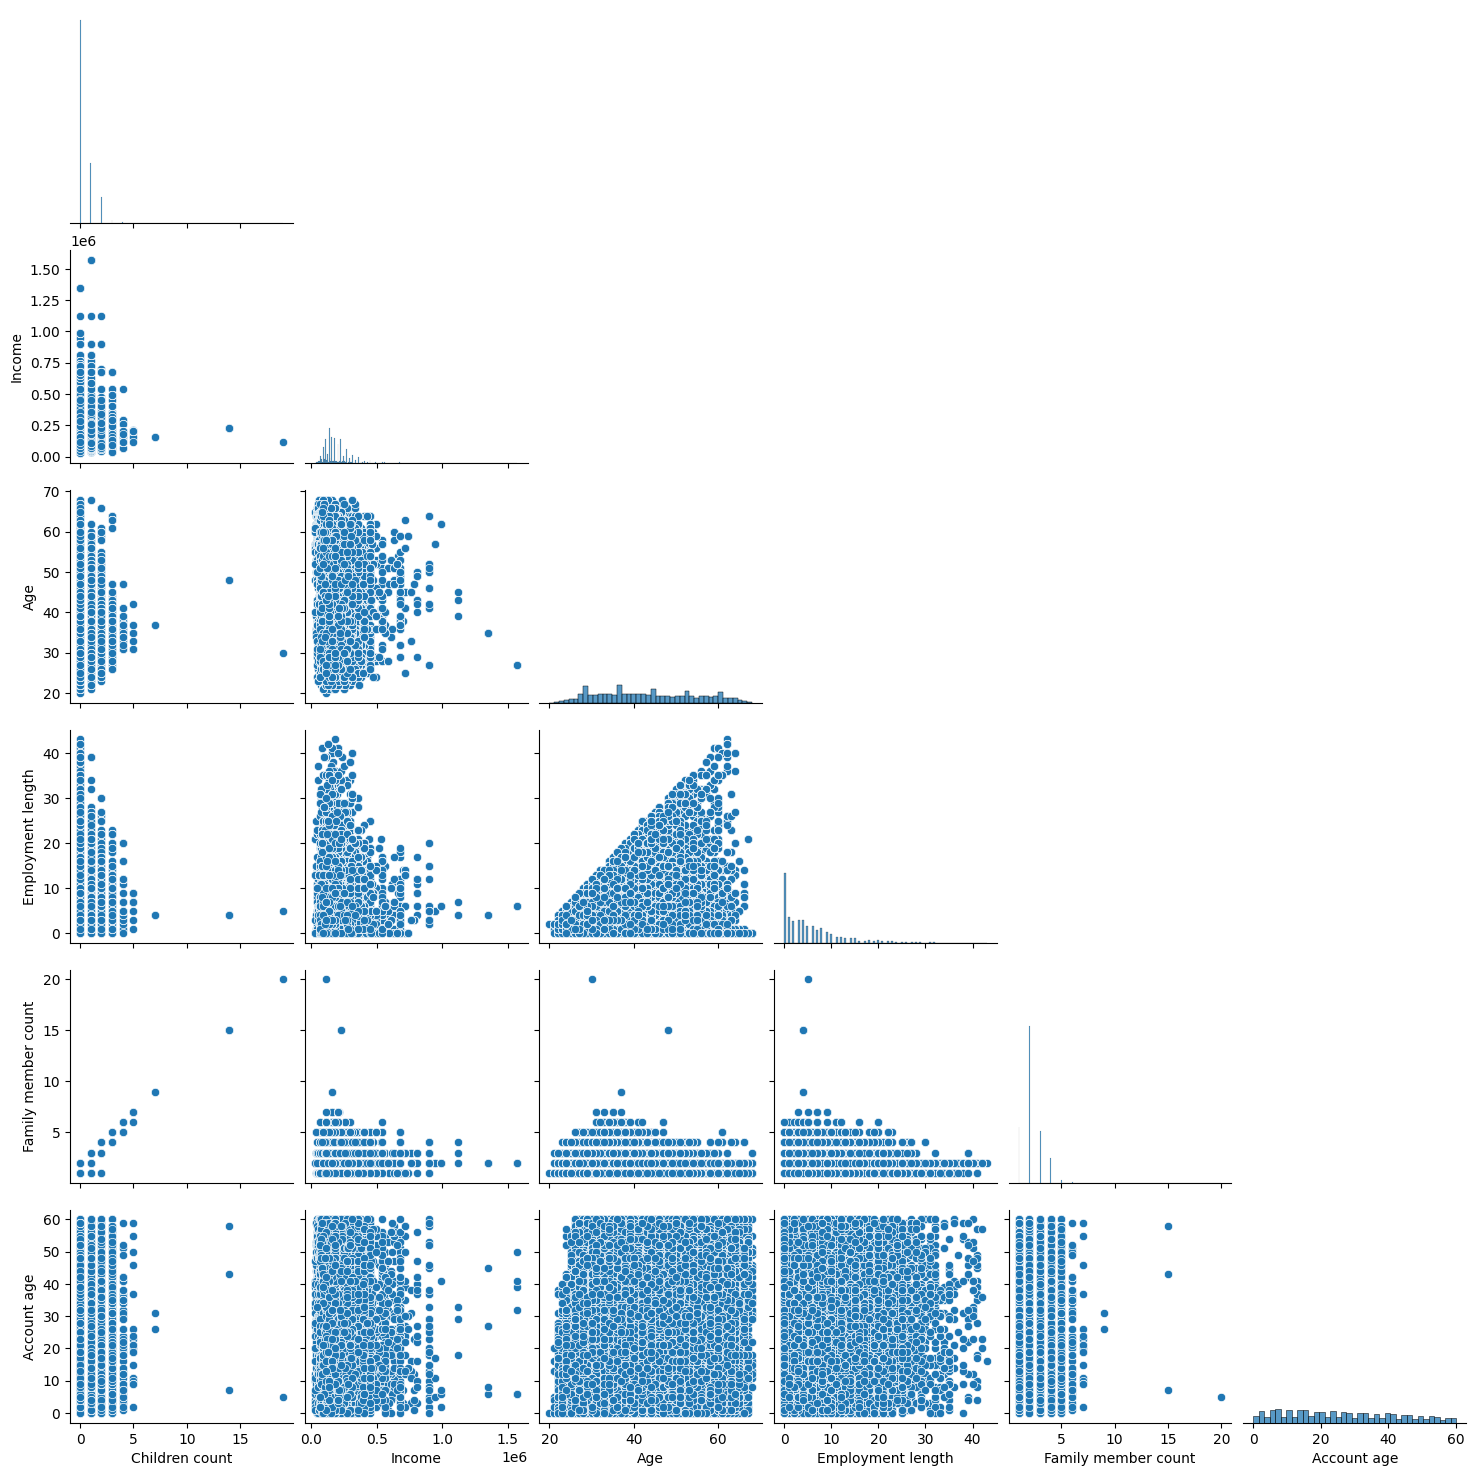

In [46]:
# Drop unnecessary columns first
subset_data = full_data.drop(['Is high risk'], axis=1)

# Then run the pairplot
sns.pairplot(subset_data, corner=True)
plt.show()

### Correlations

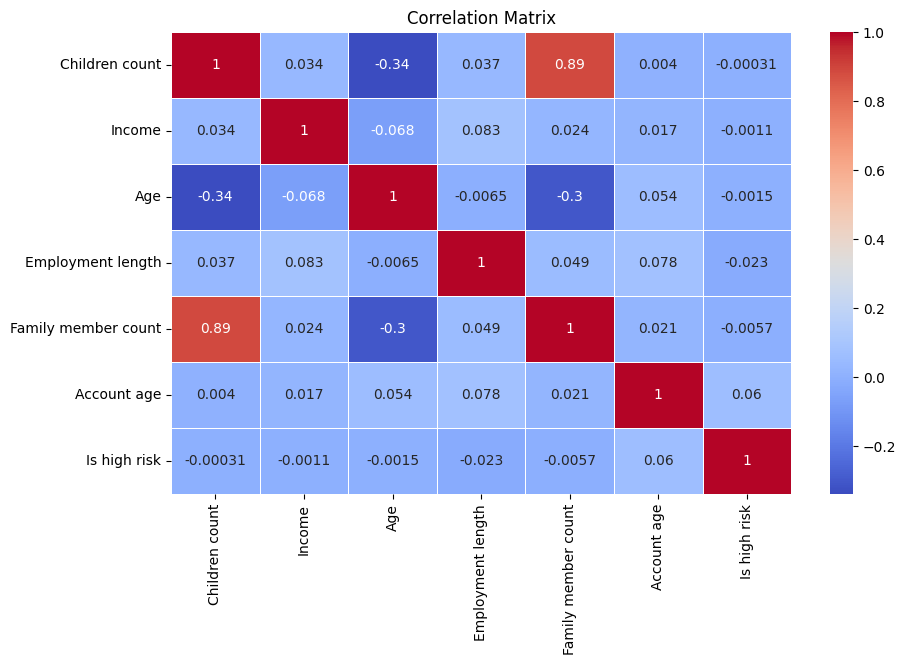

In [47]:
# Step 1: Select numerical columns (excluding 'Has a mobile phone')
numeric_data = full_data.select_dtypes(include=['float64', 'int64']).drop('Has a mobile phone', axis=1, errors='ignore')

# Step 2: Compute correlation matrix
corr_matrix = numeric_data.corr()

# Step 3: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Interesting Feature Relationships

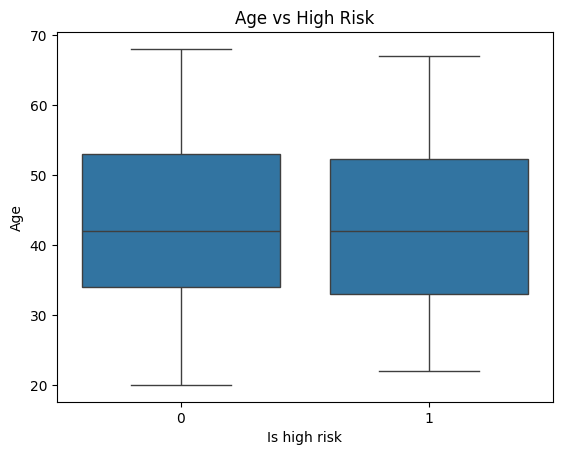

In [48]:
sns.boxplot(x='Is high risk', y='Age', data=full_data)
plt.title("Age vs High Risk")

plt.show()

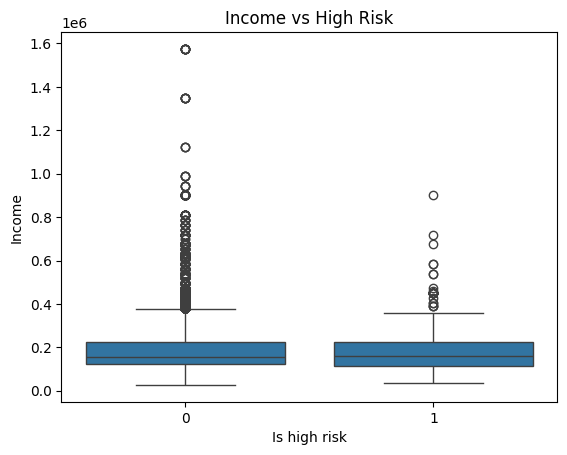

In [49]:
sns.boxplot(x='Is high risk', y='Income', data=full_data)
plt.title("Income vs High Risk")

plt.show()

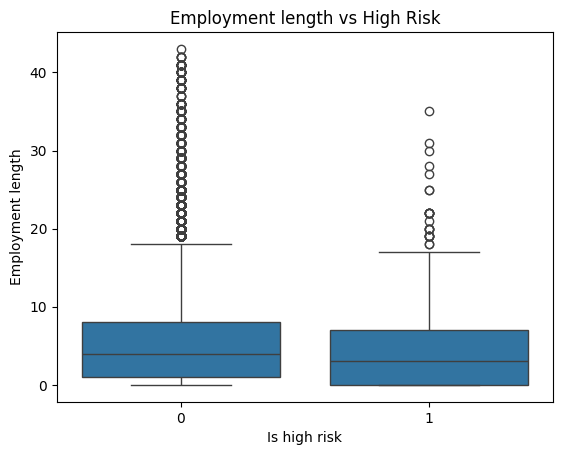

In [50]:
sns.boxplot(x='Is high risk', y='Employment length', data=full_data)
plt.title("Employment length vs High Risk")

plt.show()

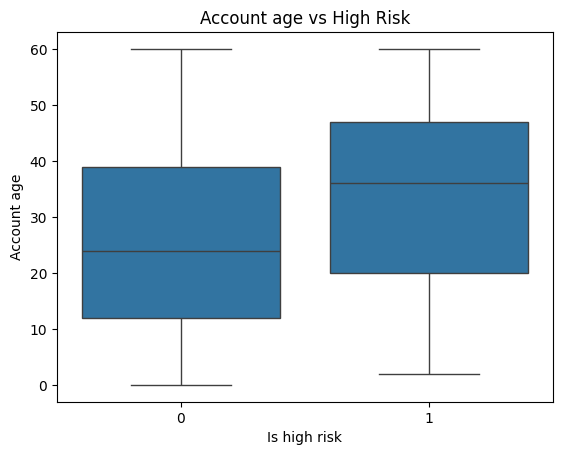

In [51]:
sns.boxplot(x='Is high risk', y='Account age', data=full_data)
plt.title("Account age vs High Risk")

plt.show()

## Questions About the dataset

### Which age group is more likely to be approved?

C:\Users\User\AppData\Local\Temp\ipykernel_6044\3500623942.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_approval = full_data.groupby('Age_Group')['Is high risk'].mean().reset_index()
C:\Users\User\AppData\Local\Temp\ipykernel_6044\3500623942.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age_Group', y='Is high risk', data=age_approval, palette='viridis')


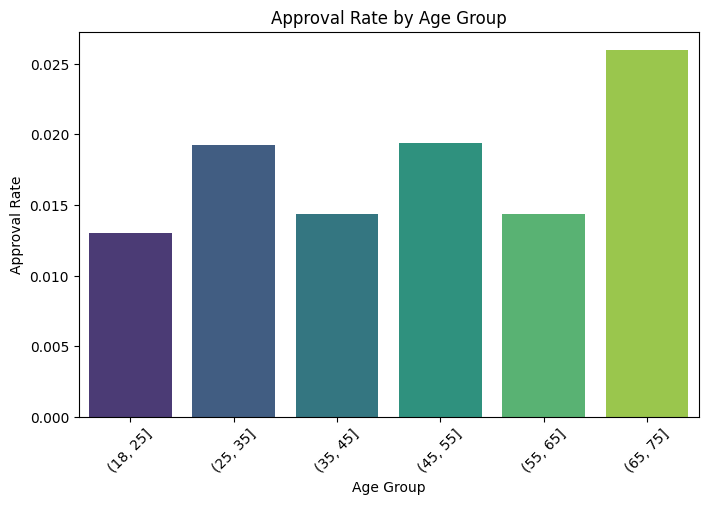

In [52]:
age_bins = [18, 25, 35, 45, 55, 65, 75]
full_data['Age_Group'] = pd.cut(full_data['Age'], bins=age_bins)

age_approval = full_data.groupby('Age_Group')['Is high risk'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='Age_Group', y='Is high risk', data=age_approval, palette='viridis')
plt.title("Approval Rate by Age Group")
plt.ylabel("Approval Rate")
plt.xlabel("Age Group")
plt.xticks(rotation=45)
plt.show()

### Does income level affect approval?

C:\Users\User\AppData\Local\Temp\ipykernel_6044\200484669.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_approval = full_data.groupby('INCOME_BIN')['Is high risk'].mean().reset_index()


C:\Users\User\AppData\Local\Temp\ipykernel_6044\200484669.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='INCOME_BIN', y='Is high risk', data=income_approval, palette='coolwarm')


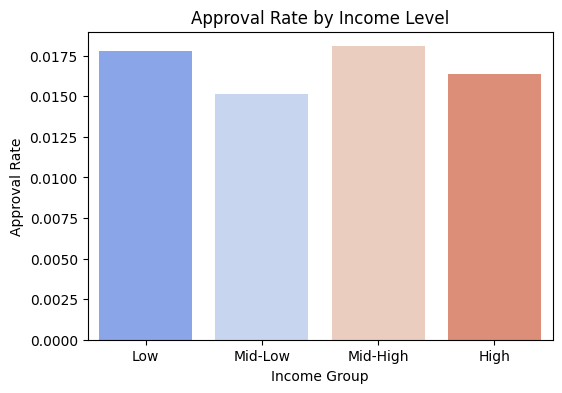

In [53]:
full_data['INCOME_BIN'] = pd.qcut(full_data['Income'], q=4, labels=["Low", "Mid-Low", "Mid-High", "High"])

income_approval = full_data.groupby('INCOME_BIN')['Is high risk'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='INCOME_BIN', y='Is high risk', data=income_approval, palette='coolwarm')
plt.title("Approval Rate by Income Level")
plt.ylabel("Approval Rate")
plt.xlabel("Income Group")
plt.show()

### Do people with fewer dependents get approved more?

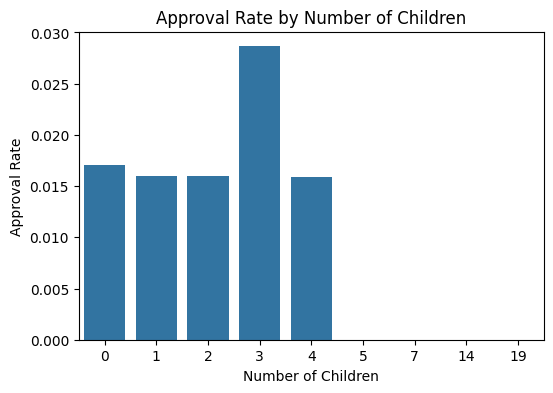

In [54]:
dep_approval = full_data.groupby('Children count')['Is high risk'].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(x='Children count', y='Is high risk', data=dep_approval)
plt.title("Approval Rate by Number of Children")
plt.ylabel("Approval Rate")
plt.xlabel("Number of Children")
plt.show()

### Are working professionals more likely to get approved?

C:\Users\User\AppData\Local\Temp\ipykernel_6044\958805457.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Is high risk', y='Education level', data=edu_approval, palette='Set3')


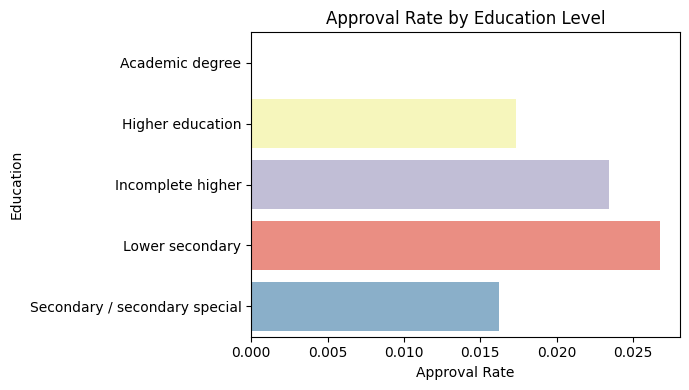

In [55]:
edu_approval = full_data.groupby('Education level')['Is high risk'].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(x='Is high risk', y='Education level', data=edu_approval, palette='Set3')
plt.title("Approval Rate by Education Level")
plt.xlabel("Approval Rate")
plt.ylabel("Education")
plt.tight_layout()
plt.show()

### Is there a difference in approval by education level?

C:\Users\User\AppData\Local\Temp\ipykernel_6044\1002926099.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Is high risk', y='Job title', data=occ_approval, palette='magma')


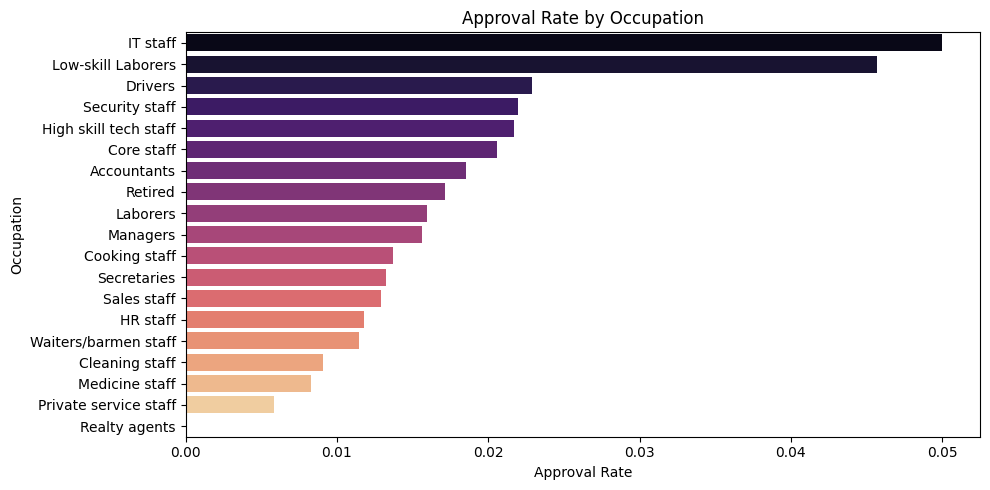

In [56]:
if 'Job title' in full_data.columns:
    occ_approval = full_data.groupby('Job title')['Is high risk'].mean().sort_values(ascending=False).reset_index()

    plt.figure(figsize=(10,5))
    sns.barplot(x='Is high risk', y='Job title', data=occ_approval, palette='magma')
    plt.title("Approval Rate by Occupation")
    plt.xlabel("Approval Rate")
    plt.ylabel("Occupation")
    plt.tight_layout()
    plt.show()
else:
    print("OCCUPATION_TYPE column not found.")